In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import cv2 as cv
import glob
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from mpl_toolkits.mplot3d import Axes3D

input_folder="Photos/"

# Obtener siluetas de un conjunto de imágenes

Una vez realizado las imágenes a las distintas figuras, el siguiente paso será **obtener las siluetas de las mismas.**

- 1º **Transformar imagen a niveles de grises:**
- 2º **Eliminar ruido de la imagen gris:** Para este filtrado, se prefirió utilizar un filtrado de suavizado por media, ya que devolvía mejores resultados que el suavizado por Gauss.
- 3º **Capturar contorno de la imagen suavizada**
- 4º **Con ese contorno umbralizado, se aplica operación morfológica de cierre para unir contornos incompletos**
- 5º **Con este nuevo contorno, se rellena y se obtiene la silueta**



**EXPERIMENTACIONES REALIZADAS:**
- 1º**Aplicar realce de Laplance:** Al hacerlo después del suavizado,esto no sólo realzaba la figura, sino la imagen entera, por lo que a la hora de umbralizar hay partes de las imágenes que son detectadas que no pertenecen a la figura, por lo que tras aplicar varias transformaciones estas se expanden.

In [97]:
def get_silhouettes_from_input_folder(input_folder_location,exit_folder_location,apply_trim=False,has_holes=False):
    silhouettes=[]
    content = os.listdir(input_folder_location)
    extensions=[".jpg",".png",".jpeg"]
    for file in content:
        if os.path.isfile(os.path.join(input_folder_location,file)) and os.path.splitext(file)[1].lower() in extensions:
            sil=get_silhouette_from_image(os.path.join(input_folder_location,file),apply_trim,has_holes)
            silhouettes.append(sil)
    return silhouettes

def trim_image(image,margen):
        gris = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        #margen=0.16
        color = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        h=color.shape[0]
        w=color.shape[1]
        margen_h=int(h*margen)
        margen_w=int(w*margen)
        color=color[int(h/2)-margen_h:int(h/2)+margen_h,int(w/2)-margen_w:int(w/2)+margen_w]
        image = color
        return image
def enhanced_laplance(imagen):
    laplacian = cv.Laplacian(imagen, cv.CV_64F)

    # Convertir a uint8 desde float
    laplacian = np.uint8(np.absolute(laplacian))
    imagen=imagen-laplacian
    return imagen

def get_silhouette_from_image(input_image,apply_trim=False,has_holes=False):
    original = cv.imread(cv.samples.findFile(input_image))

    #En caso de necesitar escalar la imagen, aplicar apply_trim=true
    if(apply_trim):
        original=trim_image(original,margen=0.16)

    #1ºPasar a gris y reducir ruido
    gris = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
    median = cv.medianBlur(gris,11)
    _, imagen_binaria = cv.threshold(median, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    plt.imshow(imagen_binaria,cmap="gray")
    imagen_binaria = imagen_binaria.astype(np.uint8)
    plt.title('1º IMAGEN BINARIZADA')
    plt.figure()
    th2=median
    if(has_holes):
        th2 = cv.adaptiveThreshold(median,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
        cv.THRESH_BINARY,11,2)
        plt.imshow(th2,cmap="gray")
        plt.title('2º IMAGEN UMBRALIZADA PARA CONTORNOS')
        plt.figure()
        
    #median=enhanced_laplance(median)
    plt.imshow(median,cmap="gray")
    plt.title('3º Suavizado')
    plt.figure()
    
    #2º Capturar contornos
    canny = cv.Canny(th2, 0, 150)
    
    if(has_holes):
        retr_method=cv.RETR_CCOMP
    else:
        retr_method=cv.RETR_EXTERNAL
    
    (contornos,jerarquias) = cv.findContours(canny.copy(), retr_method, cv.CHAIN_APPROX_NONE)
    black_background = np.zeros_like(original)
    cv.drawContours(black_background, contornos, -1, (255,255,255), -1)
    plt.imshow(black_background,cmap="gray")
    plt.title('4ºContorno capturado')
    plt.figure()
    
    #3º Aplicar Operación morfológica de cierre para unir contornos, y rellenar contornos
    
        
    kernel =cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
    erosionada = cv.morphologyEx(canny, cv.MORPH_TOPHAT, kernel)
    
    kernel1 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
    imagen_cerrada = cv.morphologyEx(erosionada, cv.MORPH_CLOSE, kernel1)
    (contornos,_) = cv.findContours(imagen_cerrada.copy(), retr_method, cv.CHAIN_APPROX_NONE)
    black_background = np.zeros_like(original,dtype=np.uint8)
    cv.drawContours(black_background, contornos, -1,(255,255,255), -1)
    plt.imshow(black_background)
    plt.title('5ºContorno cerrado y rellenado')
    plt.figure()
    
    black_background = black_background.astype(np.uint8)
    black_background = cv.cvtColor(black_background, cv.COLOR_BGR2GRAY)
    notbinary=cv.bitwise_not(imagen_binaria)
    notbinary=notbinary.astype(np.uint8)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(20,20))
    clean = cv.morphologyEx(notbinary, cv.MORPH_CLOSE, kernel)
    if notbinary.shape == black_background.shape:
        orr = cv.bitwise_or(clean, black_background)
        plt.imshow(orr, cmap="gray")
        plt.title('6º Operación OR de Contorno e Imagen binarizada')
        plt.figure()
    else:
        print("Error: Las dimensiones de las imágenes no coinciden.")

    return orr
    

In [ ]:
for i, jerarquia in enumerate(jerarquias[0]):
    # jerarquia[3] es el índice del contorno padre; si es 0 o -1, es un contorno de nivel superior
    if jerarquia[3] == 0:
        # Rellena el contorno de nivel 1
        cv2.drawContours(imagen, contornos, i, (0,255,0), thickness=-1)

# PRUEBAS SOBRE TAZAS

**Estudio de los resultados:**
- No importa el color del objeto, la silueta devuelta proporciona una aproximación del objeto de interes.
- TIPOS DE DETECCIÓN DE CONTORNOS: https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga819779b9857cc2f8601e6526a3a5bc71


C:\Users\andre\AppData\Local\Temp\ipykernel_2416\1166555676.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


5

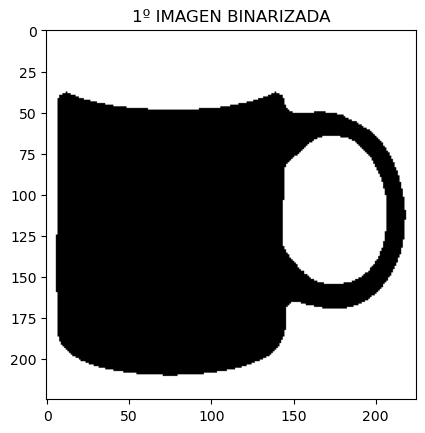

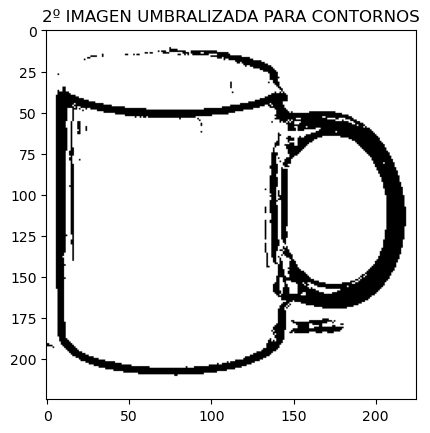

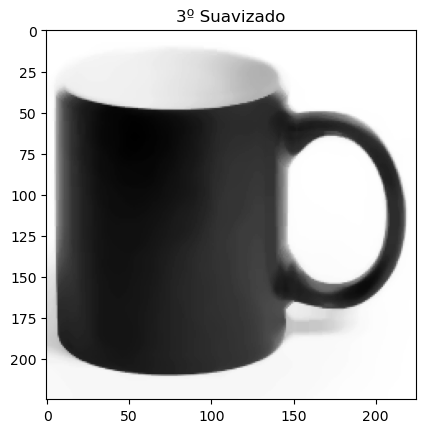

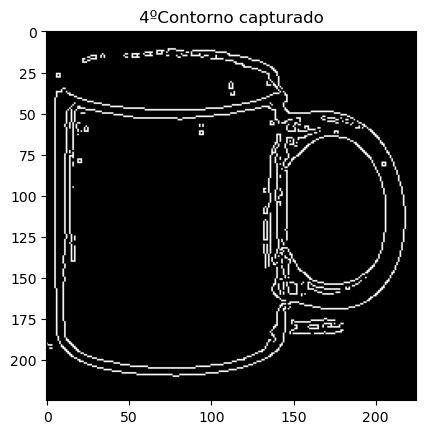

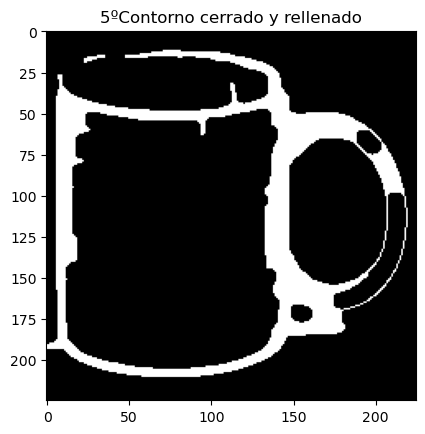

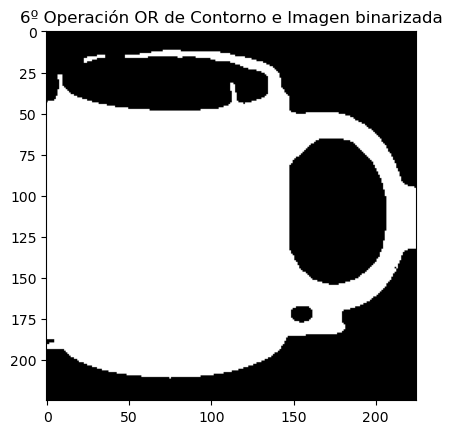

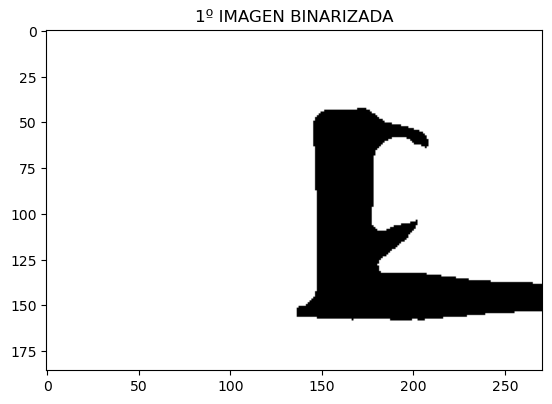

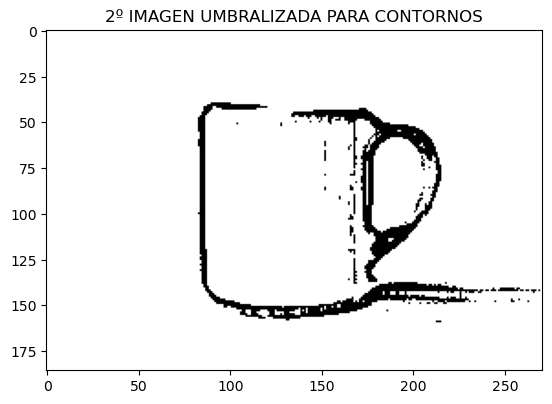

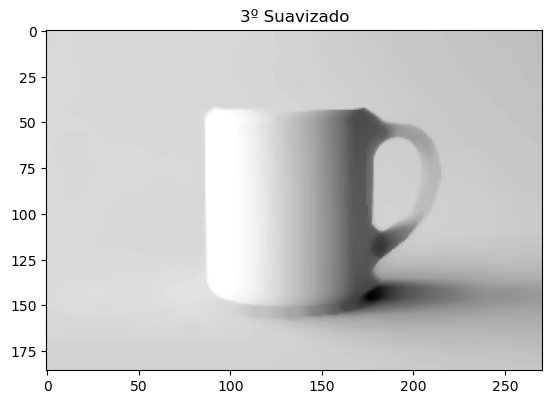

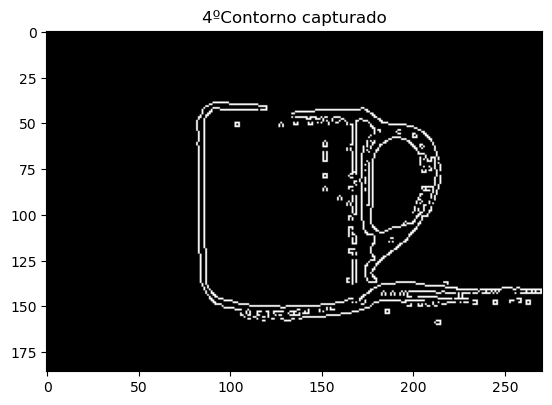

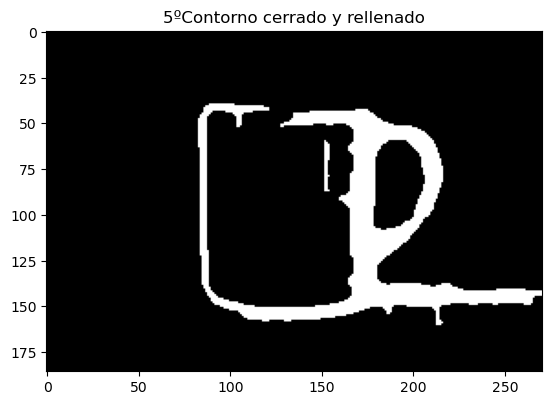

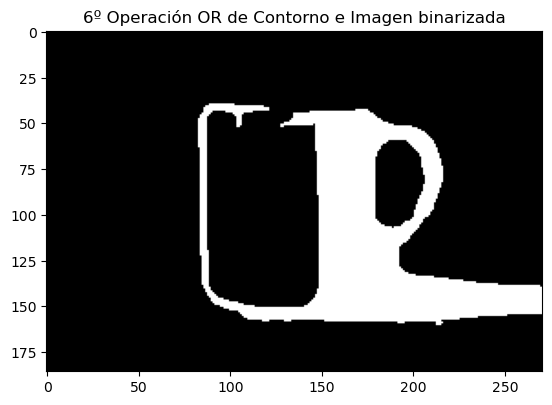

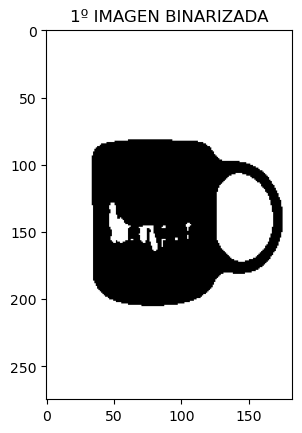

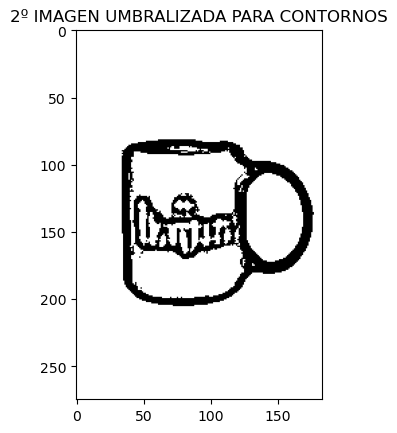

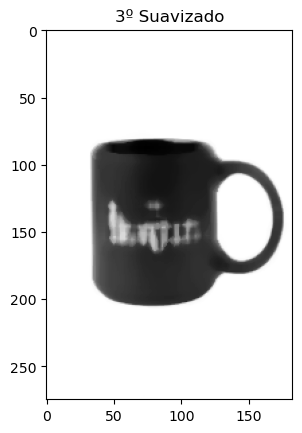

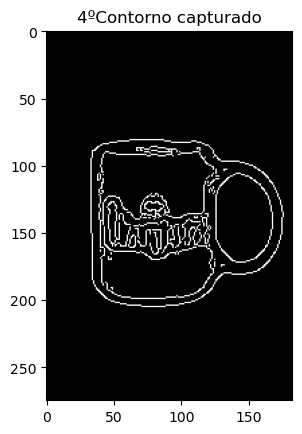

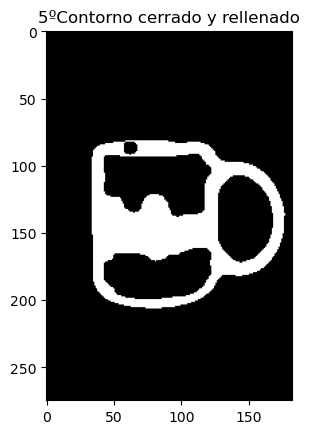

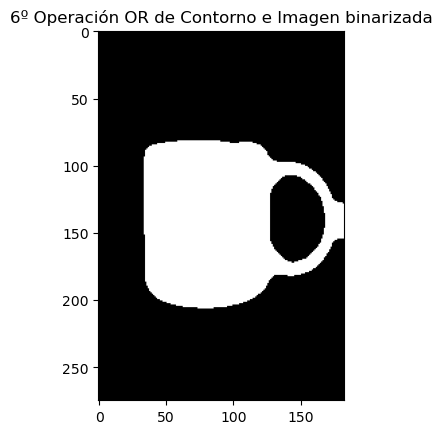

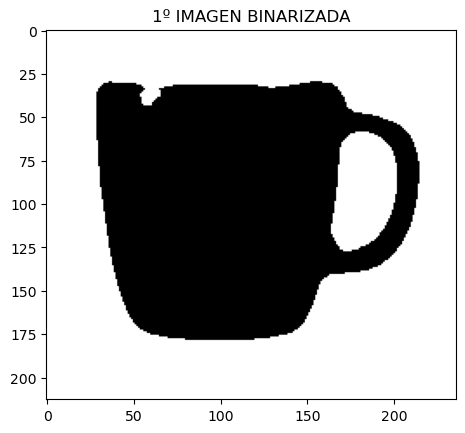

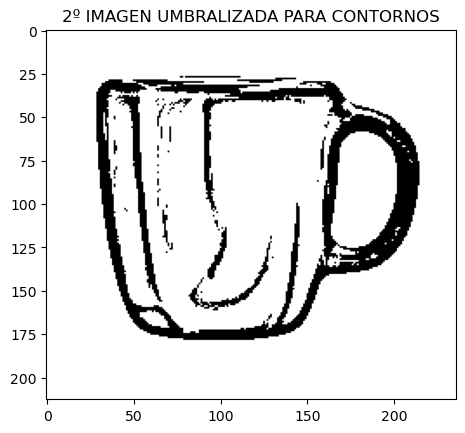

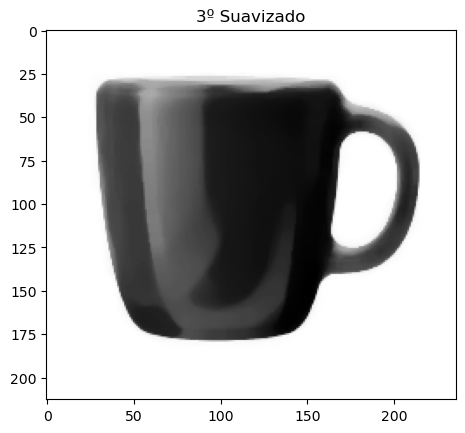

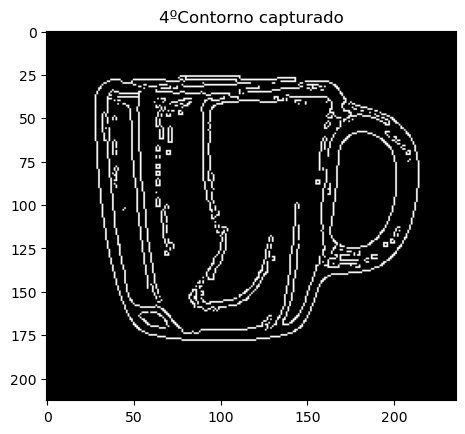

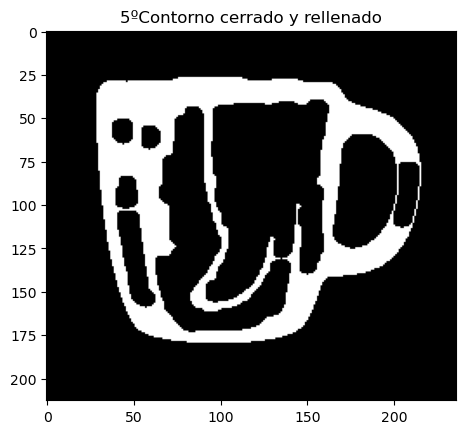

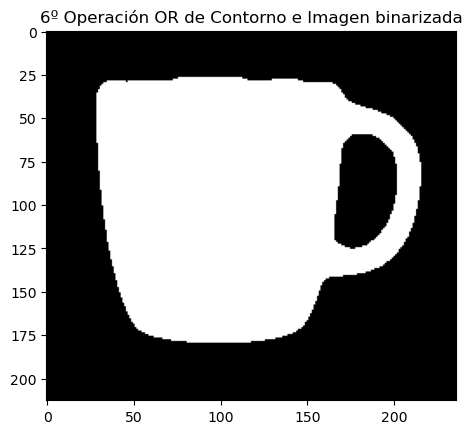

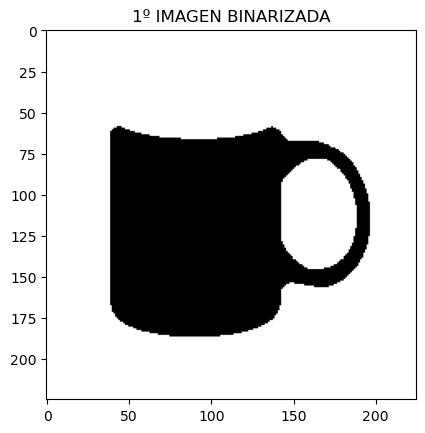

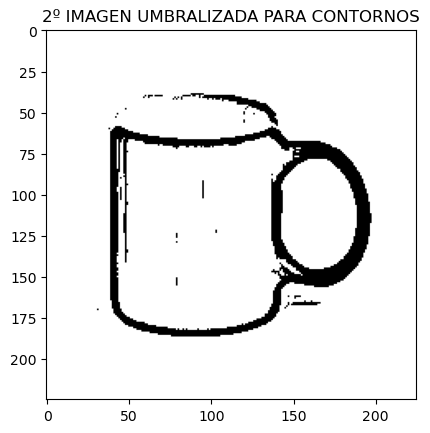

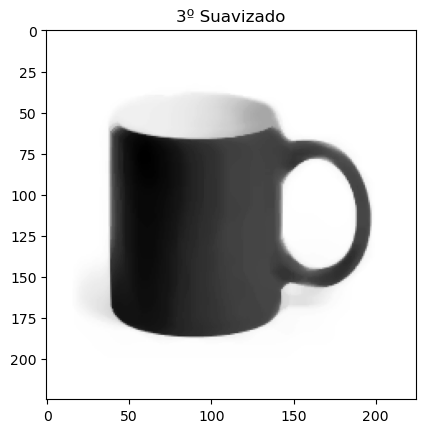

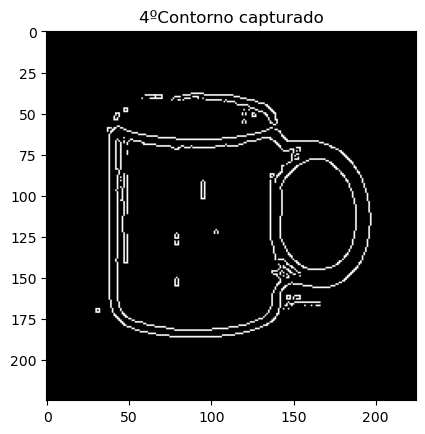

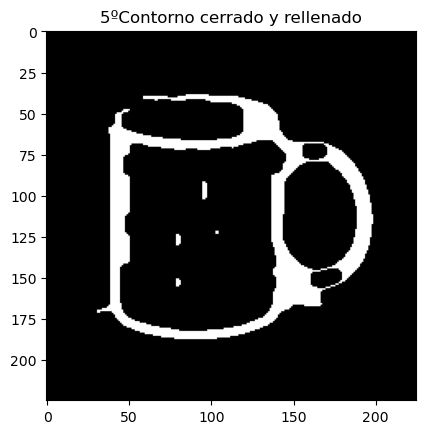

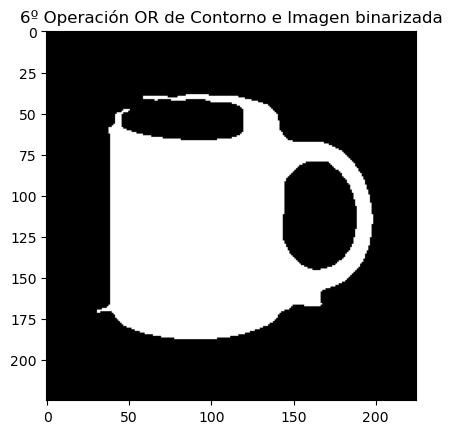

<Figure size 640x480 with 0 Axes>

In [98]:
data=get_silhouettes_from_input_folder("Tazas/","Photos/",False,has_holes=True)
len(data)

In [ ]:
#HACER OPERACIÓN OR DE IMAGEN BINARIA  Y CONTORNO

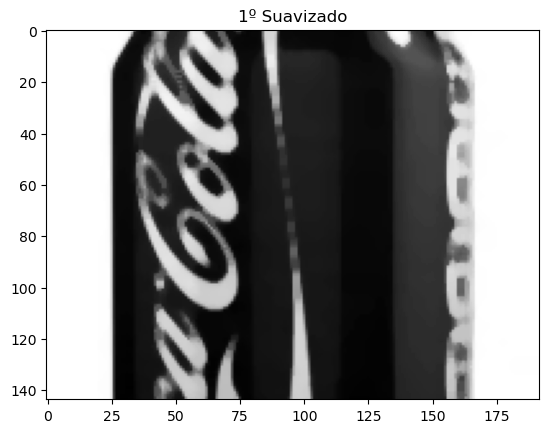

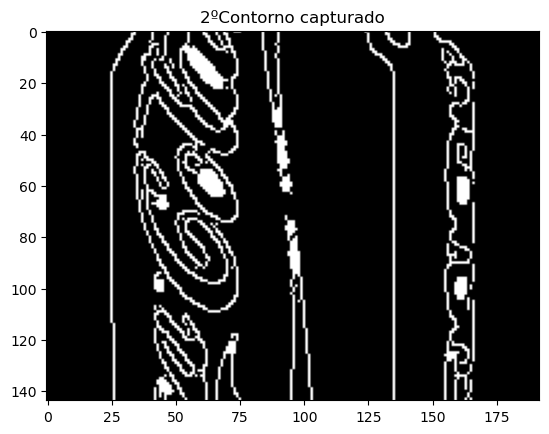

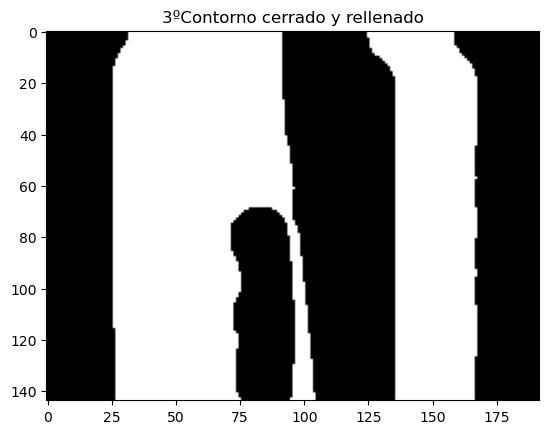

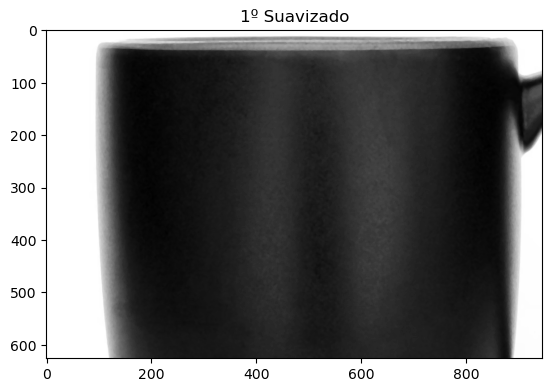

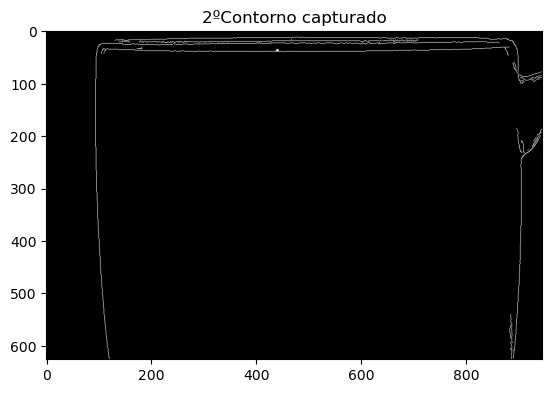

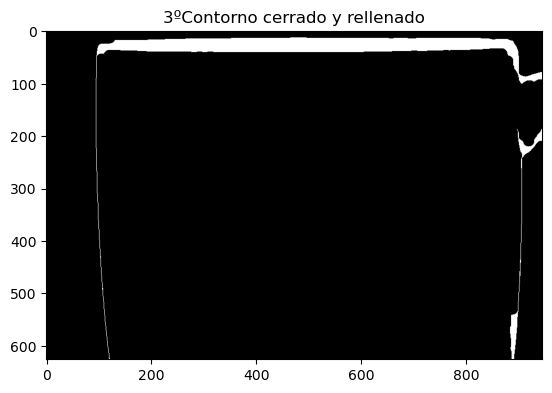

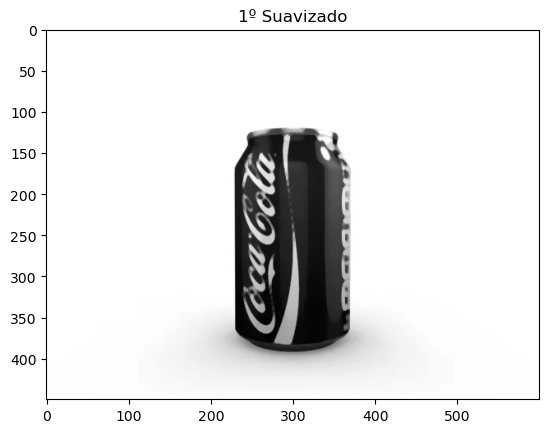

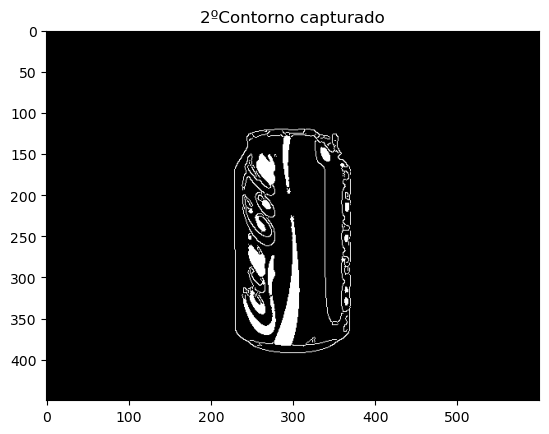

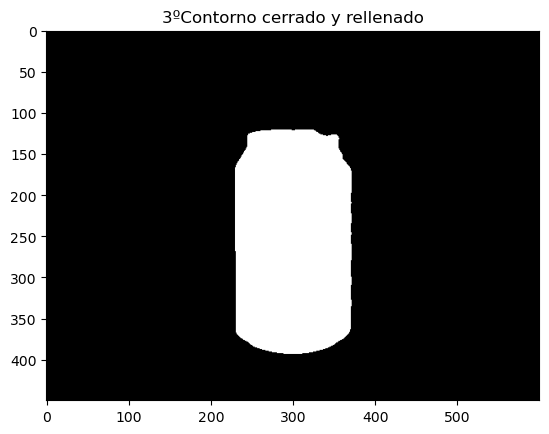

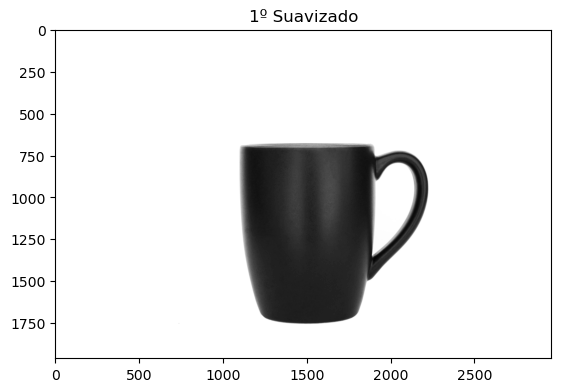

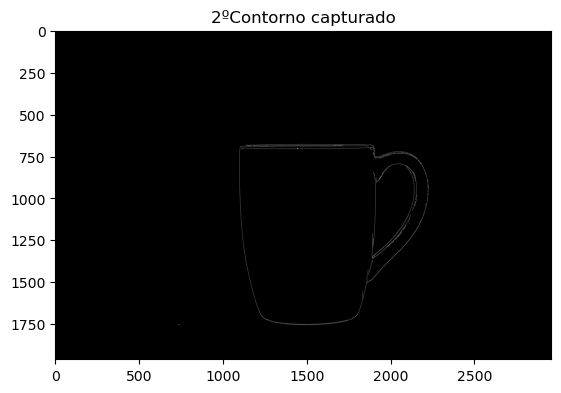

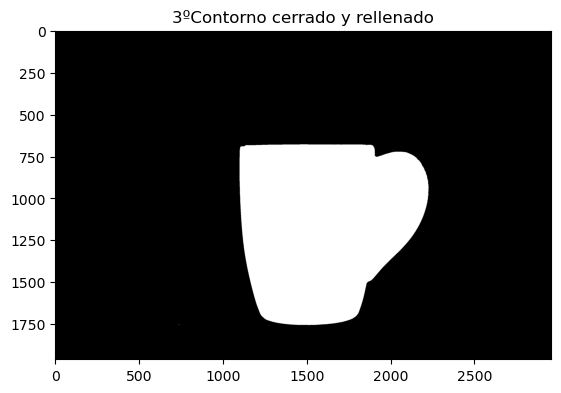

<Figure size 640x480 with 0 Axes>

In [8]:
data=get_silhouettes_from_input_folder(input_folder,"Photos/vistas/",True)
len(data)
d=get_silhouette_from_image("Photos/cocacola.jpg",False)
d1=get_silhouette_from_image("Photos/taza.jpg",False)

In [4]:
cv.imwrite("silueta1.jpg",data[2])
cv.imwrite("silueta2.jpg",data[3])
silueta1=cv.imread("silueta1.jpg")
silueta2=cv.imread("silueta2.jpg")

print(silueta1.shape)
print(silueta2.shape)


(512, 288, 3)
(512, 288, 3)
